In [21]:
import matplotlib.pyplot as plt
import numpy as np
from process import *
from saliency import *

root = "/home/kavra/Datasets/medical/cvi_eyetracking/asc_data_v1/"
trial = "Freeviewingstillimage_36_cutout.jpg"

# TODO: Perform Mann-Whitney test on CVI - ctrl additive to Welch's t-test

ids = [i for i in os.listdir(root) if i.endswith('.asc')]
ctrl_ids = [i.split(".")[0] for i in ids if i.split('_')[0].startswith("2")]
cvi_ids = [i.split(".")[0] for i in ids if i.split(".")[0] not in ctrl_ids]

In [22]:
this_trial = ImageTrial(root, trial, "smaps")
a = this_trial.load_trial_img()

IndexError: list index out of range

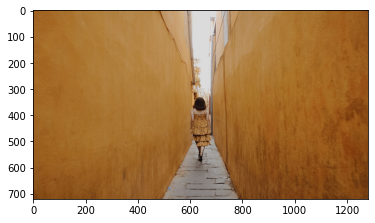

In [20]:
plt.imshow(a)

In [17]:
for trial in TRIAL_LIST:
    for i in ctrl_ids + cvi_ids:
        sub0 = Subject(root, i)
        data0, fr0 = sub0.extract_data(trial, vel=False)
        if len(data0) < 1000:
            print(len(data0))
    continue

ValueError: could not convert string to float: 'I.. '

In [15]:
sub = Subject(root, "1015_1")
data = sub.extract_data(trial, vel=False)
fix_analyzer = FixationAnalyzer(root, out)
a = fix_analyzer.fixation_map(trial)

In [ ]:
durations_ctrl = []
for subject in ctrl_ids:
    sub = Subject(root, subject)
    out = sub.extract_fixations(trial_name=trial)
    fix_analyzer = FixationAnalyzer(root, out)
    dur = fix_analyzer.number_of_fixations()
    print(dur)
    durations_ctrl.append(dur)

durations_cvi = []
for subject in cvi_ids:
    sub = Subject(root, subject)
    out = sub.extract_fixations(trial_name=trial)
    fix_analyzer = FixationAnalyzer(root, out)
    dur = fix_analyzer.number_of_fixations()
    durations_cvi.append(dur)

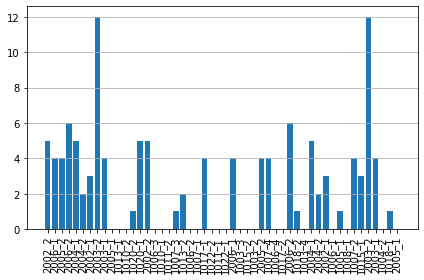

In [9]:
names = ctrl_ids + cvi_ids
t = list(range(len(names)))

plt.bar(t, durations_ctrl + durations_cvi)
plt.xticks(t, names, rotation=90)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

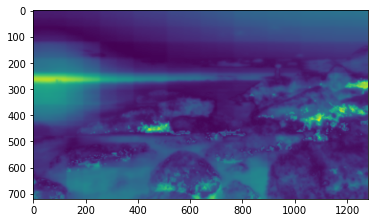

In [40]:
smap = np.load(os.path.join("output/extra", "saliency_maps", trial[:-4], trial[:-4] + "_color.npy"))
smap = (smap - np.min(smap))/(np.max(smap) - np.min(smap))
plt.imshow(smap);